# Import libraries and set up data

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


contacts_file = ("contacts.tsv")
contacts = pd.read_csv(contacts_file, sep="\t")

searches_file = ("searches.tsv")
searches = pd.read_csv(searches_file, sep="\t")

In [2]:
#Convert date columns to datetime data type

contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']
contacts['accepted'] = contacts['ts_accepted_at'].notna() #add a boolean that represents if the host accepted the inquirie
contacts['booked'] = contacts['ts_booking_at'].notna() #add a boolean that represetns if the contact lead to a booking
contacts['difference_contact_reply'] = contacts['ts_contact_at'] - contacts['ts_reply_at'] 

### Correlation matrix PreNormalization

            n_guests  n_messages  accepted    booked
n_guests    1.000000   -0.034093 -0.009157 -0.048828
n_messages -0.034093    1.000000  0.493332  0.603536
accepted   -0.009157    0.493332  1.000000  0.667249
booked     -0.048828    0.603536  0.667249  1.000000


C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\2537150333.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat_contacts = contacts.corr()


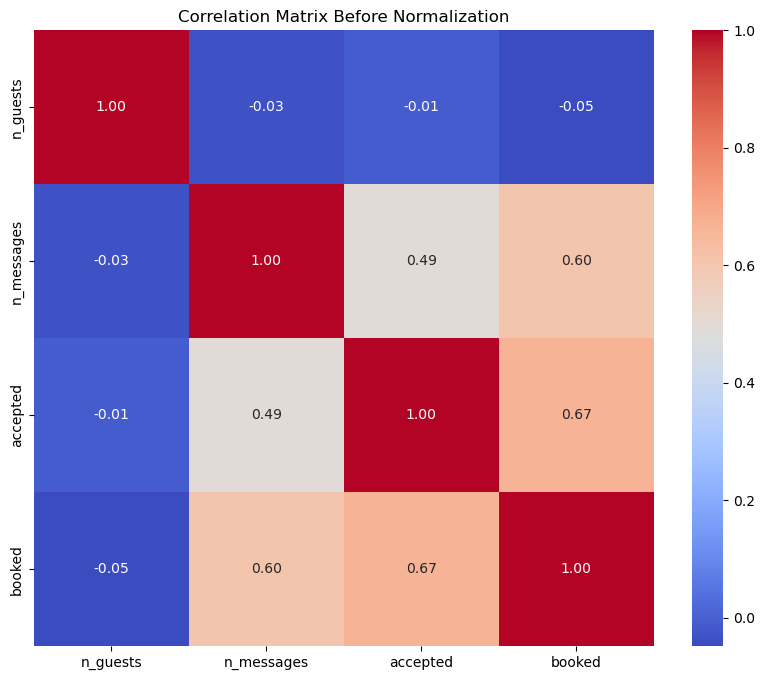

In [3]:
corrmat_contacts = contacts.corr()
print(corrmat_contacts)
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat_contacts, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before Normalization')
plt.show()

In [4]:
#Convert to total seconds for calculation later
for i in range(0,len(contacts)):
    contacts['length_stay'][i] = contacts['length_stay'][i].total_seconds()
    contacts['difference_contact_reply'][i] = contacts['difference_contact_reply'][i].total_seconds()

C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\1228209881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['length_stay'][i] = contacts['length_stay'][i].total_seconds()
C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\1228209881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['difference_contact_reply'][i] = contacts['difference_contact_reply'][i].total_seconds()


In [5]:
#normalize 
# Zscore normalization (assumes relatively normal distribution)
contacts['Norm_difference_contact_reply'] = (contacts['difference_contact_reply'] 
                                                     - contacts['difference_contact_reply'].mean()) / contacts['difference_contact_reply'].std()
contacts['Norm_length_stay'] = (contacts['length_stay'] 
                                                  - contacts['length_stay'].mean()) / contacts['length_stay'].std()

### Clipped Data set (and then merged)

In [26]:
# YOU MUST RUN THE FUNCTIONS THAT CORRESPOND TO clip_All FOR THIS TO RUN
clipped_contacts, clipped_searches = clip_All(contacts,searches)
booked = clipped_contacts[clipped_contacts['booked'] == True].copy()

### Sets up unique contacts df for later

In [11]:
unique_contacts = contacts.groupby('id_guest').agg({
    'n_messages': 'sum',  # Sum n_messages
    'accepted': 'sum',  # Sum number of accepted inquiries
    'booked': 'sum',  # Sum of agg booking conf
}).reset_index()
unique_contacts = contacts.groupby('id_guest').agg({
    'n_messages': 'sum',  # Sum n_messages
    'accepted': 'sum',  # Sum number of accepted inquiries
    'booked': 'sum',  # Sum of agg booking conf
}).reset_index()

searches['room_filter_use'] = searches['filter_room_types'].notna()

unique_searches = searches.groupby('id_user').agg({
    'n_searches': 'sum',  # Sum n_messages
    'room_filter_use': 'sum'}).reset_index()

unique_merged = unique_contacts.merge(unique_searches, left_on='id_guest', right_on='id_user')
unique_merged['room_filter_use'] = unique_merged['room_filter_use'] > 0
unique_merged = unique_merged.drop(columns = ['id_user'])
unique_merged['booked'] = unique_merged['booked'] > 0

### Correlation matrix for unique merged set

                 n_messages  accepted    booked  n_searches  room_filter_use
n_messages         1.000000  0.725899  0.304471    0.191909         0.039642
accepted           0.725899  1.000000  0.352233    0.120997         0.020411
booked             0.304471  0.352233  1.000000   -0.020815        -0.022043
n_searches         0.191909  0.120997 -0.020815    1.000000         0.158771
room_filter_use    0.039642  0.020411 -0.022043    0.158771         1.000000


C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\3154464927.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat_unique = unique_merged.corr()


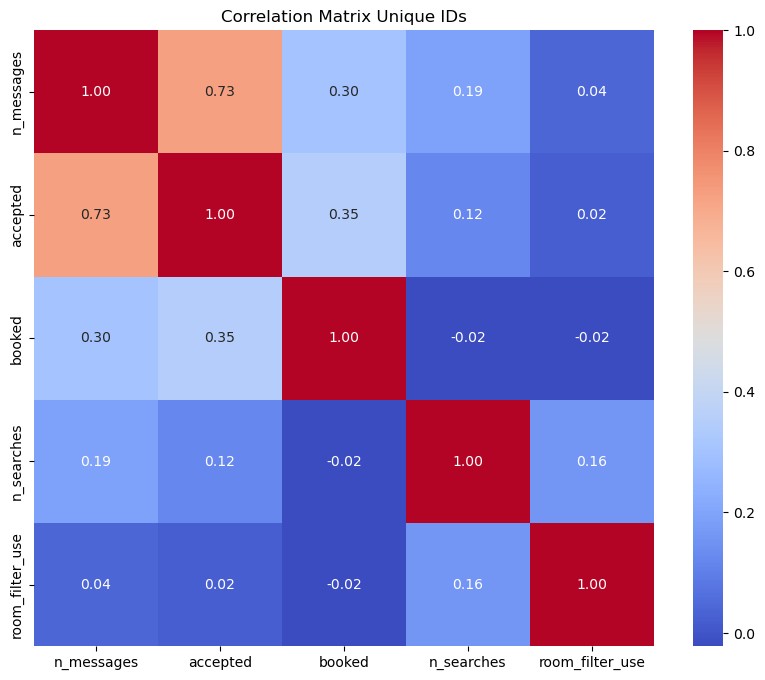

In [12]:
corrmat_unique = unique_merged.corr()
print(corrmat_unique)
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat_unique, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Unique IDs')
plt.show()

### Drops NaN for certain cols in contacts

In [13]:
contacts_dropped = contacts.dropna(subset=['Norm_difference_contact_reply','Norm_length_stay'])

In [14]:
contacts_dropped[['Norm_difference_contact_reply','Norm_length_stay']] = contacts_dropped[['Norm_difference_contact_reply','Norm_length_stay']].astype(np.float64)

C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\1858555232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts_dropped[['Norm_difference_contact_reply','Norm_length_stay']] = contacts_dropped[['Norm_difference_contact_reply','Norm_length_stay']].astype(np.float64)


### Correlation matrix after normalization (data loss ~ 600-800 samples)

C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\2782564479.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat_contacts_norm = contacts_dropped.corr()


                               n_guests  n_messages  accepted    booked  \
n_guests                       1.000000   -0.045050 -0.022225 -0.059029   
n_messages                    -0.045050    1.000000  0.463419  0.588348   
accepted                      -0.022225    0.463419  1.000000  0.653271   
booked                        -0.059029    0.588348  0.653271  1.000000   
Norm_difference_contact_reply -0.039610    0.089319  0.125009  0.103591   
Norm_length_stay              -0.062595   -0.026048 -0.054455 -0.100472   

                               Norm_difference_contact_reply  Norm_length_stay  
n_guests                                           -0.039610         -0.062595  
n_messages                                          0.089319         -0.026048  
accepted                                            0.125009         -0.054455  
booked                                              0.103591         -0.100472  
Norm_difference_contact_reply                       1.000000         

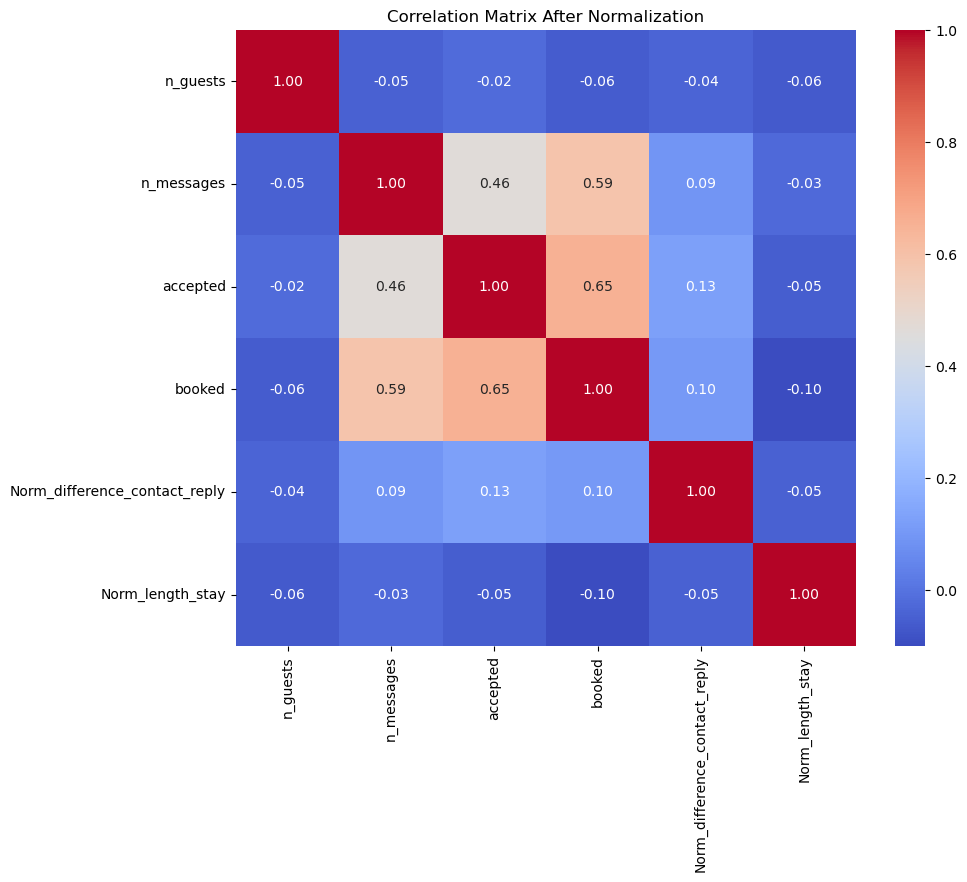

In [15]:
corrmat_contacts_norm = contacts_dropped.corr()
print(corrmat_contacts_norm)
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat_contacts_norm, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix After Normalization')
plt.show()

## Unclipped Contacts & Unique data 

### Contacts model (logistic regression)

In [16]:
xx = contacts[['n_messages','accepted']].values
yy = contacts['booked'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=42)

# Create a logistic regression model
model_cont = LogisticRegression()

# Fit the model on the training data
model_cont.fit(X_train, y_train)

# Predict on the testing data
y_pred = model_cont.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9035143769968051


In [17]:
# Perform cross-validation
cv_scores = cross_val_score(model_cont, xx, yy, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Cross-Validation Scores: [0.91054313 0.89648562 0.89392971 0.89194373 0.90217391]
Mean CV Score: 0.8990152227024995
Std CV Score: 0.006710249406422689


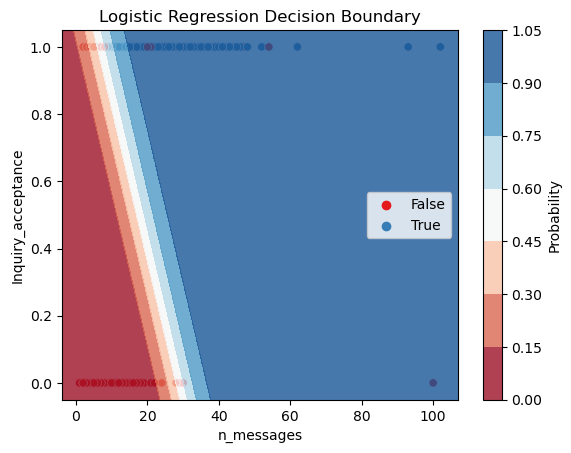

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Plot decision boundary
sns.scatterplot(x=xx[:, 0], y=xx[:, 1], hue=yy, palette='Set1')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xxz, yyz = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Pr = model_cont.predict_proba(np.c_[xxz.ravel(), yyz.ravel()])[:, 1]

# Plot decision boundary
Pr = Pr.reshape(xxz.shape)
plt.contourf(xxz, yyz, Pr, cmap='RdBu', alpha=0.8)
plt.colorbar(label='Probability')
plt.xlabel('n_messages')
plt.ylabel('Inquiry_acceptance')
plt.title('Logistic Regression Decision Boundary')
plt.show()


### Unique model (random forest)

In [19]:
W = unique_merged[['n_messages','accepted','n_searches','room_filter_use']].values
Z = unique_merged['booked']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(W, Z, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8280060882800608
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.72      0.75       240
        True       0.85      0.89      0.87       417

    accuracy                           0.83       657
   macro avg       0.82      0.81      0.81       657
weighted avg       0.83      0.83      0.83       657



In [20]:
from sklearn.feature_selection import SelectFromModel
# Select features based on feature importance
feature_selector = SelectFromModel(rf_classifier, threshold=0.1)
feature_selector.fit(W, Z)

# Transform the dataset to include only selected features
X_selected = feature_selector.transform(W)

# Print the selected feature indices
selected_indices = feature_selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

Selected Feature Indices: [0 1 2]


In [21]:
W = unique_merged[['n_messages','accepted','n_searches']].values
Z = unique_merged['booked']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(W, Z, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8295281582952816
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.72      0.76       240
        True       0.85      0.89      0.87       417

    accuracy                           0.83       657
   macro avg       0.82      0.81      0.81       657
weighted avg       0.83      0.83      0.83       657



In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, W, Z, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())


Cross-Validation Scores: [0.83561644 0.82191781 0.81582953 0.81402439 0.83079268]
Mean CV Score: 0.8236361695808739
Std CV Score: 0.008378845281919947


CONSISTENT SCORES w/ LOW STD = GOOD

### Unique model (logistic regression)

In [23]:
eks = unique_merged[['n_messages','accepted','n_searches','room_filter_use']].values
why = unique_merged['booked']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(eks,why, test_size=0.2, random_state=42)

# Create a logistic regression model
model_unique = LogisticRegression(max_iter=5000)

# Fit the model on the training data
model_unique.fit(X_train, y_train)

# Predict on the testing data
y_pred = model_unique.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8751902587519026


In [24]:
cv_scores = cross_val_score(model_unique, eks, why, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Cross-Validation Scores: [0.85388128 0.86605784 0.85083714 0.87347561 0.86737805]
Mean CV Score: 0.8623259828488695
Std CV Score: 0.008568207202346068


## Clipped Contacts & Unique data

### Correlation matrix Clipped Contacts

In [27]:
clipped_unique_contacts = clipped_contacts.groupby('id_guest').agg({
    'n_messages': 'sum',  # Sum n_messages
    'accepted': 'sum',  # Sum number of accepted inquiries
    'booked': 'sum',  # Sum of agg booking conf
}).reset_index()
clipped_unique_contacts = clipped_contacts.groupby('id_guest').agg({
    'n_messages': 'sum',  # Sum n_messages
    'accepted': 'sum',  # Sum number of accepted inquiries
    'booked': 'sum',  # Sum of agg booking conf
}).reset_index()

clipped_searches['room_filter_use'] = clipped_searches['filter_room_types'].notna()

clipped_unique_searches = clipped_searches.groupby('id_user').agg({
    'n_searches': 'sum',  # Sum n_messages
    'room_filter_use': 'sum'}).reset_index()

clipped_unique_merged = clipped_unique_contacts.merge(clipped_unique_searches, left_on='id_guest', right_on='id_user')
clipped_unique_merged['room_filter_use'] = clipped_unique_merged['room_filter_use'] > 0
clipped_unique_merged = clipped_unique_merged.drop(columns = ['id_user'])
clipped_unique_merged['booked'] = clipped_unique_merged['booked'] > 0

            n_guests  n_messages  accepted    booked
n_guests    1.000000   -0.050559 -0.043029 -0.073236
n_messages -0.050559    1.000000  0.515979  0.564264
accepted   -0.043029    0.515979  1.000000  0.818200
booked     -0.073236    0.564264  0.818200  1.000000


C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\1947788322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat_contacts = clipped_contacts.corr()


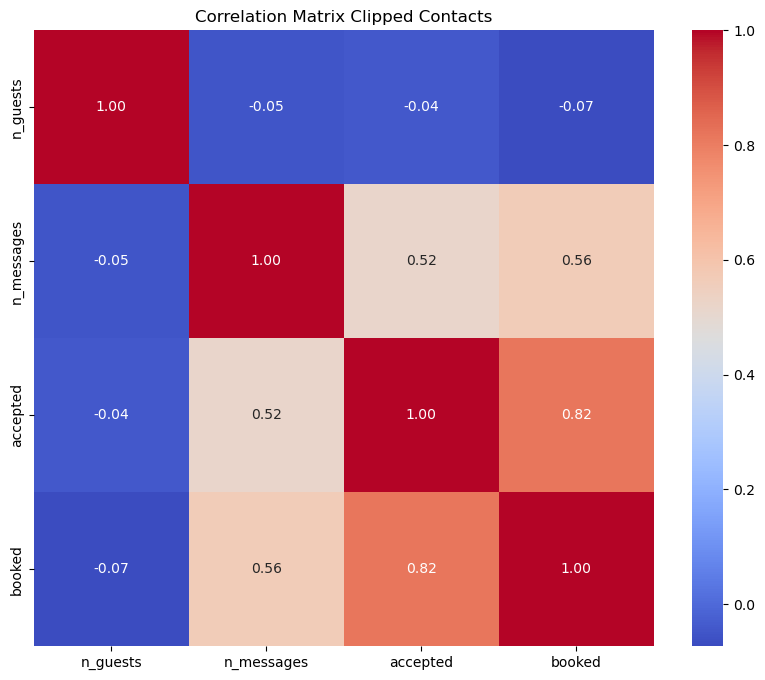

In [28]:
corrmat_contacts = clipped_contacts.corr()
print(corrmat_contacts)
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat_contacts, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Clipped Contacts')
plt.show()

                 n_messages  accepted    booked  n_searches  room_filter_use
n_messages         1.000000  0.525519  0.558867    0.033977         0.012356
accepted           0.525519  1.000000  0.824397   -0.019688         0.015419
booked             0.558867  0.824397  1.000000   -0.015138         0.011127
n_searches         0.033977 -0.019688 -0.015138    1.000000         0.116857
room_filter_use    0.012356  0.015419  0.011127    0.116857         1.000000


C:\Users\kmker\AppData\Local\Temp\ipykernel_22908\2327709767.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clipped_corrmat_unique = clipped_unique_merged.corr()


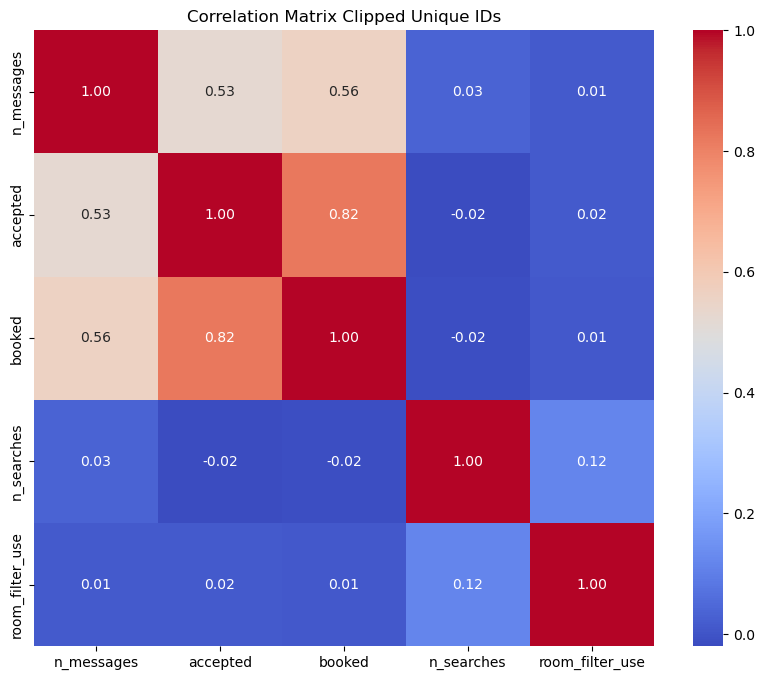

In [29]:
clipped_corrmat_unique = clipped_unique_merged.corr()
print(clipped_corrmat_unique)
plt.figure(figsize=(10, 8))
sns.heatmap(clipped_corrmat_unique, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Clipped Unique IDs')
plt.show()

### Clipped logistic reg

In [30]:
xxx = clipped_contacts[['n_messages','accepted']].values
yyy = clipped_contacts['booked'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xxx,yyy, test_size=0.2, random_state=42)

# Create a logistic regression model
clipped_model_cont = LogisticRegression()

# Fit the model on the training data
clipped_model_cont.fit(X_train, y_train)

# Predict on the testing data
y_pred = clipped_model_cont.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9265175718849841


In [31]:
# Perform cross-validation
cv_scores = cross_val_score(clipped_model_cont, xxx, yyy, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Cross-Validation Scores: [0.9057508 0.9088    0.9136    0.9152    0.92     ]
Mean CV Score: 0.9126701597444089
Std CV Score: 0.004976885495915411


### Unique clipped random forest

In [32]:
Ww = clipped_unique_merged[['n_messages','accepted','n_searches','room_filter_use']].values
Zz = clipped_unique_merged['booked']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(Ww, Zz, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clipped_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clipped_rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clipped_rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8774373259052924
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.82      0.83       129
        True       0.90      0.91      0.90       230

    accuracy                           0.88       359
   macro avg       0.87      0.87      0.87       359
weighted avg       0.88      0.88      0.88       359



In [33]:
from sklearn.feature_selection import SelectFromModel
# Select features based on feature importance
feature_selector = SelectFromModel(clipped_rf_classifier, threshold=0.1)
feature_selector.fit(Ww, Zz)

# Transform the dataset to include only selected features
X_selected = feature_selector.transform(Ww)

# Print the selected feature indices
selected_indices = feature_selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

Selected Feature Indices: [0 1 2]


In [34]:
Ww = clipped_unique_merged[['n_messages','accepted','n_searches']].values
Zz = clipped_unique_merged['booked']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(Ww, Zz, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clipped_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clipped_rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clipped_rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8969359331476323
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.84      0.85       129
        True       0.91      0.93      0.92       230

    accuracy                           0.90       359
   macro avg       0.89      0.88      0.89       359
weighted avg       0.90      0.90      0.90       359



In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
clipped_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clipped_rf_classifier, Ww, Zz, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())


Cross-Validation Scores: [0.90807799 0.91086351 0.89972145 0.92200557 0.88857939]
Mean CV Score: 0.905849582172702
Std CV Score: 0.011197633004034405


### Unique clipped logistic regression

In [36]:
clipped_eks = clipped_unique_merged[['n_messages','accepted','n_searches','room_filter_use']].values
clipped_why = clipped_unique_merged['booked']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clipped_eks,clipped_why, test_size=0.2, random_state=42)

# Create a logistic regression model
clipped_model_unique = LogisticRegression(max_iter=5000)

# Fit the model on the training data
clipped_model_unique.fit(X_train, y_train)

# Predict on the testing data
y_pred = clipped_model_unique.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9192200557103064


In [37]:
cv_scores = cross_val_score(clipped_model_unique, clipped_eks, clipped_why, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Std CV Score:", cv_scores.std())

Cross-Validation Scores: [0.90250696 0.90250696 0.91643454 0.94150418 0.92200557]
Mean CV Score: 0.916991643454039
Std CV Score: 0.014463236752921622


# Functions

In [9]:
def clip_All(contacts,searches):
  contacts = add_weekdays_column(contacts)

  contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
  contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
  contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
  contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
  contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
  contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
  contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']
  contacts['accepted'] = contacts['ts_accepted_at'].notna()
  contacts['booked'] = contacts['ts_booking_at'].notna()
  #filter to requests under 35 days
  removed_dupe_guests = remove_duplicates_keep_booking(contacts,'id_guest')
  td = np.timedelta64(35,'D')
  filtered_contacts = removed_dupe_guests[removed_dupe_guests['length_stay'] <= td]
  percentage_true = (filtered_contacts['booked'].sum() / len(filtered_contacts)) * 100
  #print(f"{1 - round(percentage_true,2)}% of the cropped outliers were booked")
  #plot_length_stay_frequency(filtered_contacts,'length_stay')
  max_guest_clip = 6
  filtered_contacts = filtered_contacts[filtered_contacts['n_guests'] <= max_guest_clip]
  percentage_true = (filtered_contacts['booked'].sum() / len(filtered_contacts['booked'])) * 100
  percentage_true = 1 - round(percentage_true,2)
  #print(f"{percentage_true}% of the cropped outliers were booked")
  max_messages_clip = 42
  filtered_contacts = filtered_contacts[filtered_contacts['n_messages'] <= max_messages_clip]
  percentage_true = (filtered_contacts['booked'].sum() / len(filtered_contacts['booked'])) * 100
  percentage_true = 1 - round(percentage_true,2)
  #print(f"{percentage_true}% of the cropped outliers were booked")
  #plot_length_stay_frequency(filtered_contacts,'length_stay')

  #CLIP SEARCHES


  #Drop filter_neighborhoods column
  #MAYBE DONT USE THIS?
  searches['ds'] = pd.to_datetime(searches['ds'])
  searches = add_weekdays_column(searches)
  searches['length_preperation'] = searches['ds_checkin'] - searches['ds']
  searches = searches.drop(columns=['filter_neighborhoods'])
  filtered_searches = searches[searches['filter_price_max'] <= 600]
  #plot_numeric_frequency(filtered_searches,'filter_price_max')

  #Remove n_nights beyond 20 days
  filtered_searches = filtered_searches[filtered_searches['n_nights'] < 20]

  return filtered_contacts, filtered_searches

In [8]:
def add_weekdays_column(df):
        """
        Adds a column 'weekdays' to the dataframe which lists the weekdays between check-in and check-out dates.
        """

        # Convert date columns to datetime objects
        df['ds_checkin'] = pd.to_datetime(df['ds_checkin'], errors='coerce')
        df['ds_checkout'] = pd.to_datetime(df['ds_checkout'], errors='coerce')

        # Function to calculate list of weekdays
        def get_weekdays(row):
            if pd.isnull(row['ds_checkin']) or pd.isnull(row['ds_checkout']):
                return None
            day_list = []
            current_day = row['ds_checkin']
            while current_day < row['ds_checkout']:
                day_list.append(current_day.strftime('%A'))
                current_day += timedelta(days=1)
            return day_list

        # Apply function to each row
        df['weekdays'] = df.apply(get_weekdays, axis=1)
        return df

In [7]:
def remove_duplicates_keep_booking(df, label_column):
    """
    Removes duplicates based on a label column while keeping rows where
    a 'booking' column is True if duplicates exist.

    Parameters:
    - df: Pandas DataFrame.
    - label_column: String, the name of the column to check for duplicates.
    """
    # Sort the DataFrame: True values in 'booking' column come first
    df_sorted = df.sort_values(by=['booked', label_column], ascending=[False, True])

    # Drop duplicates based on the label column, keeping the first (which has 'booking' = True if possible)
    result_df = df_sorted.drop_duplicates(subset=[label_column], keep='first')

    return result_df